In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', 100)

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import re
import string
import nltk
import xgboost

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

import sys
if not 'Notebooks/Individual/Jake' in sys.path:
    sys.path.append('Notebooks/Individual/jake')
from functions import ScoreModel, FeatureImp

import IPython
sound_file = '../../../data/sounds/puzzle_solved_jingle.wav'

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix

from textblob import TextBlob, Word
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("../../../data/reviews.csv")
df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll pause for a moment and write a review while I wai...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A comput...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you know how to play, very easy to master. I've made it ...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to the horror tag on Steam.I first played this game ...,1


In [3]:
col = ["review_id", "year", "title"]

df = df.drop(col, axis = 1)

df.head(10)

,user_review,user_suggestion
0,I'm scared and hearing creepy voices. So I'll pause for a moment and write a review while I wai...,1
1,"Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A comput...",1
2,"A littly iffy on the controls, but once you know how to play, very easy to master. I've made it ...",1
3,"Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode...",1
4,Not many games have the cute tag right next to the horror tag on Steam.I first played this game ...,1
5,"Early Access ReviewIt's pretty cute at first, but then later gets horrifying and it really does ...",1
6,Great game. it's a cute little horror game that progressively gets darker and scarier. It has a ...,1
7,Spooky's Jump Scare Mansion is a Free Retro maze game with jump scares and death. It worked on ...,1
8,"Somewhere between light hearted, happy parody and being afraid of the dark lies Spooky's House o...",0
9,This game with its cute little out of the wall pop-ups that scared the living light out of me I ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_review      17494 non-null  object
 1   user_suggestion  17494 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 273.5+ KB


In [5]:
df["user_suggestion"].value_counts(normalize=True)

1    0.569795
0    0.430205
Name: user_suggestion, dtype: float64

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
punct = string.punctuation

lemma = nltk.WordNetLemmatizer()

In [7]:
def clean_reviews(reviews):
    reviews = "".join([word for word in reviews if word not in string.punctuation])
    tokens = re.split('\W+', reviews)
    reviews = [lemma.lemmatize(word) for word in tokens if word not in stopwords]
    return reviews

In [8]:
df['clean_review'] = df['user_review'].apply(lambda x: clean_reviews(x.lower()))

df.head(10)

,user_review,user_suggestion,clean_review
0,I'm scared and hearing creepy voices. So I'll pause for a moment and write a review while I wai...,1,"[im, scared, hearing, creepy, voice, ill, pause, moment, write, review, wait, heart, beat, retur..."
1,"Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A comput...",1,"[best, game, better, sam, pepper, youtube, account, 1010what, youll, need, playa, computersome, ..."
2,"A littly iffy on the controls, but once you know how to play, very easy to master. I've made it ...",1,"[littly, iffy, control, know, play, easy, master, ive, made, floor, 1000, due, certain, circumst..."
3,"Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode...",1,"[great, game, fun, colorful, thata, side, note, though, getting, windowed, mode, computer, hate,..."
4,Not many games have the cute tag right next to the horror tag on Steam.I first played this game ...,1,"[many, game, cute, tag, right, next, horror, tag, steami, first, played, game, late, 2014, comin..."
5,"Early Access ReviewIt's pretty cute at first, but then later gets horrifying and it really does ...",1,"[early, access, reviewits, pretty, cute, first, later, get, horrifying, really, jumpscare, speci..."
6,Great game. it's a cute little horror game that progressively gets darker and scarier. It has a ...,1,"[great, game, cute, little, horror, game, progressively, get, darker, scarier, sense, humor, ive..."
7,Spooky's Jump Scare Mansion is a Free Retro maze game with jump scares and death. It worked on ...,1,"[spookys, jump, scare, mansion, free, retro, maze, game, jump, scare, death, worked, win, 10, lo..."
8,"Somewhere between light hearted, happy parody and being afraid of the dark lies Spooky's House o...",0,"[somewhere, light, hearted, happy, parody, afraid, dark, lie, spookys, house, jump, scare, taske..."
9,This game with its cute little out of the wall pop-ups that scared the living light out of me I ...,1,"[game, cute, little, wall, popups, scared, living, light, like, much, havent, played, lately, go..."


In [9]:
df_down = df.loc[df['user_suggestion'] == 0]
df_up = df.loc[df['user_suggestion'] == 1]

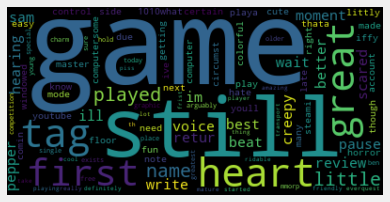

<Figure size 1440x720 with 0 Axes>

In [10]:
wordcloud = WordCloud(max_words=100, width=400, height=200).generate(str(df_up["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

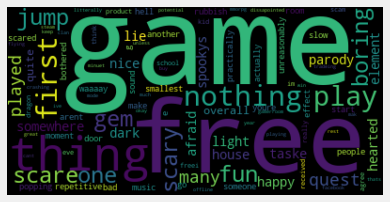

<Figure size 1440x720 with 0 Axes>

In [11]:
wordcloud = WordCloud(max_words=100, width=400, height=200).generate(str(df_down["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

In [12]:
vector = TfidfVectorizer(analyzer=clean_reviews, ngram_range=(2, 2))
X = vector.fit_transform(df["user_review"])

X_df = pd.DataFrame(X.toarray())
X_df.columns = vector.get_feature_names()
X_df.head(3)

,,0,00,000,0000,00000,000001,00001,00002,0001,...,현질유도는,현질유도도,혹은,혼자서,황망한,황무지,ﾉ,ﾉಥДಥﾉ,ﾌﾌ,ﾚ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#X = X_df.drop("user_suggestion", axis = 1, inplace=True)
y = df["user_suggestion"]

X_train, X_test, y_train, y_test = train_test_split(X_df, y, random_state=57)

baseline = RandomForestClassifier(n_estimators=100)
baseline.fit(X_train, y_train)

RandomForestClassifier()

In [15]:
ScoreModel(baseline, X_train, y_train)

Accuracy:   0.9998475609756098
F1 Score:   0.9998654648190501
Recall:     0.9998654648190501
Precision:  0.9998654648190501
ROC_AUC:    0.9998448125923983


In [16]:
ScoreModel(baseline, X_test, y_test)

Accuracy:   0.8097850937357111
F1 Score:   0.8459829692706407
Recall:     0.9013806706114399
Precision:  0.7970003487966516
ROC_AUC:    0.7924521623856546


In [17]:
IPython.display.Audio(sound_file, autoplay=True, rate=1000)